In [ ]:
# default_exp density_ratio_em

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from multiinstance.em import generateBags
from multiinstance.utils import estimate
from multiinstance.nnpu import getPosterior as getNNPUPosterior
from multiinstance.vpu import train as getVPUPosterior
from multiinstance.ranker import RankNet

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from easydict import EasyDict
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

from dist_curve.transforms import getOptimalTransform, trainOOBClassifier

from multiinstance.ranker import RankNet, LambdaRankNN

from tqdm.notebook import trange

from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

In [ ]:
# export
class DensityRatioEM:
    def __init__(self, bags,n_clusters):
        self.bags = bags
        self.n_clusters = n_clusters
        self.findGlobalClusters()
        self.tau_posS = []
        self.tau_uS = []
        self.clusterAlphaHats = np.zeros(n_clusters)
        for cnum in trange(n_clusters,desc="transforms and class prior estimation"):
            self.estimateClusterClassPrior(cnum)

        self.getEta()
    
    def findGlobalClusters(self):
        "Run K-Means on the positives from all bags then assign each unlabeled point to a cluster based on the resulting clusters of K-Means"
        globalPositives = np.concatenate([b.X_pos for b in self.bags])
        kmeans = KMeans(n_clusters=self.n_clusters).fit(globalPositives)
        # Cluster Unlabeled
        for bagNum,b in enumerate(self.bags):
            self.bags[bagNum].unlabeled_cluster_assignment = kmeans.predict(b.x_unlabeled)
            self.bags[bagNum].positive_cluster_assignment = kmeans.predict(b.X_pos)
        self.kmeans = kmeans

    def getEta(self):
        self.trueEta = np.stack(list(b.eta for b in self.bags))
        self.gamma = np.stack(list(b.gamma for b in self.bags))
        """
        bagClusterCounts = np.zeros_like(self.trueEta)
        for bnum,b in enumerate(self.bags):
            bagCounts = np.unique(b.unlabeled_cluster_assignment,return_counts=True)[1]
            bagClusterCounts[bnum] = bagCounts
        bagClusterCounts = bagClusterCounts / bagClusterCounts.sum(0)
        self.trueclusterAlphaHats = np.zeros(self.n_clusters)
        for cnum in range(self.n_clusters):
            self.trueclusterAlphaHats[cnum] = bagClusterCounts[:,cnum].dot(self.trueEta[:,cnum])
        """

    def getClusterMembers(self,cnum):
        "Get the unlabeled and positive points across all bags that were assigned the given cluster"
        unlabeledInCluster = [b.x_unlabeled[b.unlabeled_cluster_assignment == cnum] for b in self.bags]
        posInCluster = [b.X_pos[b.positive_cluster_assignment == cnum] for b in self.bags]
        unlabeled = np.concatenate(unlabeledInCluster)
        positive = np.concatenate(posInCluster)
        return unlabeled, positive
    
    def trainTransform(self,cnum):
        "Train and store the univariate PU transform for a given cluster"
        unlabeled,positive = self.getClusterMembers(cnum)
        x = np.concatenate((positive,unlabeled))
        y = np.concatenate((np.ones(positive.shape[0]),
                            np.zeros(unlabeled.shape[0])))
        tau,aucpu = trainOOBClassifier(x,y)
        tau_pos = np.ascontiguousarray(tau[:positive.shape[0]].reshape((-1,1)))
        tau_u = np.ascontiguousarray(tau[positive.shape[0]:].reshape((-1,1)))
        self.tau_posS.append(tau_pos)
        self.tau_uS.append(tau_u)

    def estimateClusterClassPrior(self,cnum):
        "Estimate the class prior for the given cluster"
        self.trainTransform(cnum)
        p,u = self.tau_posS[cnum], self.tau_uS[cnum]
        self.clusterAlphaHats[cnum],_ = estimate(p,u)

    def ratioFromPosteriorVec(self, posts, alpha):
        "convert posterior vector and class prior estimate for a cluster into a density ratio vector"
        assert alpha != 1
        assert ~np.any(posts == 0)
#         assert ~np.any(posts == 1)
        return (alpha * (1 - posts)) / (posts * (1 - alpha))
    
    def trueDensityRatio(self,cnum):
        """
        Get the true density ratio
        
        Arguments:
        - cnum : int : cluster number
        """
        # see formatComponentInfo
        comp = self.components[cnum]
        unlabeled,_ = self.getClusterMembers(cnum)
        # Positive density
        f1 = ss.multivariate_normal.pdf(unlabeled,mean=comp.posMean,cov=comp.posCov)
        # Negative density
        f0 = ss.multivariate_normal.pdf(unlabeled,mean=comp.negMean,cov=comp.negCov)
        ratios = f0/f1
        alpha = self.clusterAlphaHats[cnum]
        posts = f1 * alpha / (f1 * alpha + (1-alpha) * f0)
        #ratios = self.ratioFromPosteriorVec(posts,alpha)
        self.debugPosteriors.append(posts)
        hiddenLabels = np.concatenate([b.hiddenLabels[b.unlabeled_cluster_assignment == cnum] for b in self.bags])
        self.debugLabels.append(hiddenLabels)
        print(roc_auc_score(hiddenLabels, posts))
        return ratios

    def trainPNPosterior(self,xPN,yPN):
        "get estimated pn posterior probabilities for given data"
#         posteriors,auc =trainOOBClassifier(xPN,yPN)
#         return posteriors
        skf = StratifiedKFold()
        posteriors = np.zeros_like(yPN,dtype=float)
        for trainInds, valInds in skf.split(xPN,yPN):
            xTrain,xVal,yTrain,yVal = xPN[trainInds],xPN[valInds],yPN[trainInds],yPN[valInds]
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(32,input_shape=(xPN.shape[1],),activation="relu"),
                tf.keras.layers.Dense(32,activation="relu"),
                tf.keras.layers.Dense(32, activation = "relu"),
                tf.keras.layers.Dense(2,activation="softmax")
            ])
            model.compile("adam",loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1))
            model.fit(xTrain,tf.one_hot(yTrain,2),epochs=10,verbose=0)
            posteriors[valInds] = model.predict(xVal)[:,1]
        return posteriors

    def ratioEstimation(self,cnum):
        unlabeled,positive = self.getClusterMembers(cnum)
        hiddenLabels = np.concatenate([b.hiddenLabels[b.unlabeled_cluster_assignment == cnum] for b in self.bags]).ravel().astype(bool)
        logRatio = tf.keras.models.Sequential([
            tf.keras.layers.Dense(128,input_dim=unlabeled.shape[1],activation="relu"),
            tf.keras.layers.Dense(256,activation="relu"),
            tf.keras.layers.Dense(512,activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        xp = unlabeled[hiddenLabels]
        xn = unlabeled[~hiddenLabels]
        NN,NP = xn.shape[0],xp.shape[0]
        xp = xp[np.random.choice(np.arange(xp.shape[0]),size=max(NN,NP),replace=True)]
        xn = xn[np.random.choice(np.arange(xn.shape[0]),size=max(NN,NP),replace=True)]
        x_p = tf.keras.layers.Input(tensor=tf.convert_to_tensor(xp),name="xp")
        x_n = tf.keras.layers.Input(tensor=tf.convert_to_tensor(xn),name="xn")
        log_ratio_p = logRatio(x_p)
        log_ratio_n = logRatio(x_n)
        def _binary_crossentropy(log_ratio_p, log_ratio_q):

            loss_p = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=log_ratio_p,
                labels=tf.ones_like(log_ratio_p)
            )

            loss_q = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=log_ratio_q,
                labels=tf.zeros_like(log_ratio_q)
            )

            return tf.reduce_mean(loss_p + loss_q)
                
        class PredictionHistory(tf.keras.callbacks.Callback):
            def __init__(self):

                self.predictions = []

            def on_epoch_begin(self, epoch, logs):

                self.predictions.append(logRatio(unlabeled).numpy())
        m = tf.keras.models.Model(inputs=[x_p, x_n], outputs=[log_ratio_p, log_ratio_n])
        m.add_loss(_binary_crossentropy(log_ratio_p, log_ratio_n))
        m.compile(optimizer='rmsprop', loss=None)
        hist_pred = PredictionHistory()
        m.fit(x={"xp":xp,
                 "xn":xn},y=None,steps_per_epoch=1, epochs=500,callbacks=[hist_pred],verbose=0)
        return hist_pred.predictions[-1] * NN/NP
        
    def densityRatioFromEstimatedPNPosterior(self,cnum):
        "For a given cluster use the true PN labels to train a classifier modeling the PN posterior then calculate density ratio"
        unlabeled,positive = self.getClusterMembers(cnum)
        hiddenLabels = np.concatenate([b.hiddenLabels[b.unlabeled_cluster_assignment == cnum] for b in self.bags])
        posteriors = self.trainPNPosterior(unlabeled,hiddenLabels.astype(bool))
        self.debugLabels.append(hiddenLabels)
        self.debugPosteriors.append(posteriors)
        print("posterior auc ",roc_auc_score(hiddenLabels,posteriors))
        ratios = self.ratioFromPosteriorVec(posteriors,self.clusterAlphaHats[cnum])
        return ratios
        """
        xPN = np.concatenate((positive,unlabeled))
        yPN = np.concatenate((np.ones(positive.shape[0]),hiddenLabels)).astype(bool)
        posteriors = self.trainPNPosterior(xPN,yPN)[positive.shape[0]:]
        print("posteriors auc",roc_auc_score(hiddenLabels, posteriors))
        NP,NU = positive.shape[0], unlabeled.shape[0]
        classPrior = (NP + self.clusterAlphaHats[cnum] * NU) / (NP + NU)
        ratios = self.ratioFromPosteriorVec(posteriors, classPrior)
        return ratios
        """
        

    def getNNPUInput(self,cnum,inputType):
        """
        Get the input to AbsNNPU
        
        Arguments:
        - cnum : int : cluster number
        - inputType : {raw,transform,estimated rank,true rank} : space in which AbsNNPU will be trained

        Return Values:
        - xPU : ndarray (n,d) : instances in feature space
        - yPU : ndarray (n,) : PU labels
        - inputs : ndarray (n,k) : instances in space AbsNNPU will be trained
        """
        assert inputType in "raw,transform,estimated rank,true rank".split(",")
        unlabeled,positive = self.getClusterMembers(cnum)
        num_pos = positive.shape[0]
        xPU = np.concatenate((positive,unlabeled))
        yPU = np.concatenate((np.ones(positive.shape[0]), np.zeros(unlabeled.shape[0])))[:,None]
        if inputType == "raw":
            return xPU,yPU,xPU,num_pos
        elif inputType == "transform":
            tauPos, tauU = self.tau_posS[cnum], self.tau_uS[cnum]
            transforms = np.concatenate((tauPos, tauU))
            return xPU,yPU,transforms,num_pos
        elif inputType == "estimated rank":
            # Run RankNet or xgboost
            ranknet = RankNet()
            ranks = ranknet.train(xPU,yPU.ravel().astype(bool))[:,None]
            print("estimated ranks aucpu",roc_auc_score(yPU,ranks))
            return xPU,yPU,ranks,num_pos
        else:
            # True Rank
            puposteriorFn = self.components[cnum].dg.pu_posterior
            ranks = ss.rankdata(puposteriorFn(xPU - self.components[cnum].r))[:,None]
            ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
            return xPU,yPU,ranks,num_pos

    def estimatePosteriors(self,x,y,inputs,cnum):
        "Return the estimated pn posteriors"
        posteriors,net = getNNPUPosterior(x.astype(np.float32),
                                          y,
                                          self.clusterAlphaHats[cnum],
                                          inputs.astype(np.float32),
                                          training_args=EasyDict({'n_units': 1000,
                                                         'n_hidden': 10,
                                                         'dropout_rate': 0.5,
                                                         'maxIter': 500,
                                                         'batch_size': 128}))
        return posteriors

    def estimateClusterDensityRatio(self,cnum,inputType):
        x,y,inputs,num_pos = self.getNNPUInput(cnum,inputType)
        posteriors = self.estimatePosteriors(x,y,inputs,cnum)
        posteriors = posteriors[num_pos:]
        hiddenLabels = np.concatenate([b.hiddenLabels[b.unlabeled_cluster_assignment == cnum] for b in self.bags])
        self.debugPosteriors.append(posteriors)
        self.debugLabels.append(hiddenLabels)
        print(roc_auc_score(hiddenLabels, posteriors))
        ratios = self.ratioFromPosteriorVec(posteriors,self.clusterAlphaHats[cnum])
        return ratios

    def splitRatiosIntoBags(self,ratios,cnum):
        "given list of density ratios for all unlabeled points, separate back into lists for each bag"
        bagRatios = []
        numUnlabeled = [b.x_unlabeled[b.unlabeled_cluster_assignment == cnum].shape[0] for b in self.bags]
        endPoints = np.concatenate(([0],np.cumsum(numUnlabeled)))
        for bagNum in range(1, len(endPoints)):
            r = ratios[endPoints[bagNum - 1]:endPoints[bagNum]]
            bagRatios.append(r)
        return bagRatios
    
    def formatComponentInfo(self,componentInfo):
        """
        The components found by kmeans likely don't match the true order of the components,
        find the mapping and create EasyDicts for each comp
        
        Arguments:
        - componentInfo EasyDict with fields:
            - posMeans : length <numComps> list of (<dim>) ndarrays
            - negMeans : length <numComps> list of (<dim>) ndarrays
            - posCovs  : length <numComps> list of (<dim>,<dim>) ndarrays
            - negCovs  : length <numComps> list of (<dim>,<dim>) ndarrays
            - dgs      : list of GaussianMixtureDataGenerator objects (see multiinstance.data.gaussian_dg)
        """
        if componentInfo is None:
            self.components = None
            return
        # maps kmeans cluster to true component index
        clusterMap = cdist(self.kmeans.cluster_centers_, componentInfo.posMeans).argmin(1)
        self.components = []
        for comp in clusterMap:
            compInfo = EasyDict()
            compInfo.posMean = componentInfo.posMeans[comp]
            compInfo.negMean = componentInfo.negMeans[comp]
            compInfo.posCov = componentInfo.posCovs[comp]
            compInfo.negCov = componentInfo.negCovs[comp]
            compInfo.dg = componentInfo.dgs[comp]
            compInfo.r = componentInfo.rs[comp]
            self.components.append(compInfo)
        
    def getBagRatios(self,inputType,componentInfo=None):
        """
        Arguments:
        - inputType : {true posterior,
                       estimated posterior,
                       nnpu raw,
                       nnpu transform,
                       nnpu estimated rank,
                       nnpu true rank}
        - componentInfo : Required if inputType in {"true posterior","nnpu true rank"}
            - See self.formatComponentInfo for details
            
        """
        # NClusters x NBags size list containing the density ratio for the unlabeled points
        # from the specified bag in the specified cluster
        self.bagRatios = []
        self.debugLabels= []
        self.debugPosteriors = []
        self.formatComponentInfo(componentInfo)
        for cnum in trange(self.n_clusters):
            if inputType == "true posterior":
                ratios = self.trueDensityRatio(cnum)
            elif inputType == "estimated posterior":
                ratios = self.densityRatioFromEstimatedPNPosterior(cnum)
            elif inputType == "ratio estimation":
                ratios = self.ratioEstimation(cnum)
            elif "nnpu" in inputType:
                ratios = self.estimateClusterDensityRatio(cnum,inputType.replace("nnpu ",""))
            else:
                raise ValueError("Invalid inputType specified: {}".format(inputType))
            self.bagRatios.append(self.splitRatiosIntoBags(ratios,cnum))
        print(roc_auc_score(np.concatenate(self.debugLabels),
                            np.concatenate(self.debugPosteriors)))
    def EM(self,NIters=25):
        self.eta = np.ones((len(self.bags), self.n_clusters)) * self.clusterAlphaHats
#         self.eta = np.copy(self.trueEta)
        plt.scatter(self.eta.ravel(), self.trueEta.ravel())
        plt.plot([0,1],[0,1])
        plt.title(np.mean(np.abs(self.eta - self.trueEta)))
        plt.show()
        for em_iter in trange(NIters):
            for cnum in range(self.n_clusters):
                for bagNum,b in enumerate(self.bags):
                    ratios = self.bagRatios[cnum][bagNum]
                    eij = self.eta[bagNum,cnum]
#                     comp = self.components[cnum]
#                     unlabeled = b.x_unlabeled[b.unlabeled_cluster_assignment == cnum]
#                     # Positive density
#                     f1 = ss.multivariate_normal.pdf(unlabeled,mean=comp.posMean,cov=comp.posCov)
#                     # Negative density
#                     f0 = ss.multivariate_normal.pdf(unlabeled,mean=comp.negMean,cov=comp.negCov)
#                     f = eij * f1 + (1 - eij) * f0
#                     f = f / f.sum()
#                     self.eta[bagNum,cnum] = np.dot(posts, f)
                    posts = eij / (eij + (1-eij) * ratios)
                    self.eta[bagNum,cnum] = np.mean(posts)
            plt.scatter(self.eta.ravel(), self.trueEta.ravel())
            plt.plot([0,1],[0,1])
            plt.title(np.nanmean(np.abs(self.eta - self.trueEta)))
            plt.show()
    
    def run(self,densityRatioInputType,componentInfo=None):
        self.getBagRatios(densityRatioInputType, componentInfo=componentInfo)
        self.EM()
        self.estimateBagParameters()
    
    
    def posterior(self, bagNum, clusterNum):
        eta_i_j = self.eta[bagNum, clusterNum]
        densityRatios = self.bagRatios[clusterNum][bagNum]
        return eta_i_j / (eta_i_j + (1 - eta_i_j)*densityRatios)
    
    def getAUC(self):
        labels = []
        posts = []
        for bagNum in range(len(self.bags)):
            for cnum in range(self.n_clusters):
                posts.append(self.posterior(bagNum,cnum))
                labels.append(self.bags[bagNum].hiddenLabels[self.bags[bagNum].unlabeled_cluster_assignment == cnum])
        labels = np.concatenate(labels)
        posts = np.concatenate(posts)
        return roc_auc_score(labels, posts)

    def estimateBagParameters(self):
        N = len(self.bags)
        self.alphaHats = np.zeros(N)
        self.pi = np.zeros((N,self.n_clusters))
        self.rho = np.zeros((N,self.n_clusters))
        for bagNum, b in enumerate(self.bags):
            eta_j = self.eta[bagNum]
            label,count = np.unique(b.unlabeled_cluster_assignment,return_counts=True)
            gamma_j = np.zeros(self.n_clusters)
            for l,c in zip(label,count):
                gamma_j[l] = c / count.sum()
            alpha_j = eta_j.dot(gamma_j)
            pi_j = np.multiply(eta_j, gamma_j) / alpha_j
            rho_j = np.multiply(1 - eta_j, gamma_j) / (1 - alpha_j)
            self.alphaHats[bagNum] = alpha_j
            self.pi[bagNum] = pi_j
            self.rho[bagNum] = rho_j

# Baseline

In [ ]:
def posteriorCorrection(tau, alpha, S0S1):
    post =  alpha * S0S1 * (tau / (1 - tau))
    post = np.nan_to_num(post)
    return post

def baseline(bags,pupost=None):
    # apply transforms
    posts = []
    labels = []
    absErrs = []
    for b in tqdm(bags,leave=False):
        tau, aucpu = trainOOBClassifier(np.concatenate((b.X_pos,
                                                         b.x_unlabeled)), 
                                         np.concatenate((np.ones(b.X_pos.shape[0]),
                                                        np.zeros(b.x_unlabeled.shape[0]))))
        tau_pos = np.ascontiguousarray(tau[:b.X_pos.shape[0]].reshape((-1,1)))
        tau_u = np.ascontiguousarray(tau[b.X_pos.shape[0]:].reshape((-1,1)))
        alphaHat,_ = estimate(tau_pos, tau_u)
        alphaHat = alphaHat.numpy()[0,0]
        absErrs.append(np.abs(alphaHat - b.alpha))
        s0s1 = b.x_unlabeled.shape[0] / b.X_pos.shape[0]
        p,net = getNNPUPosterior(np.concatenate((b.X_pos,b.x_unlabeled)).astype(np.float32),
                                     np.concatenate((np.ones((tau_pos.shape[0],1)),
                                                     np.zeros((tau_u.shape[0],1)))).astype(np.int32),
                                    alphaHat,pupost=pupost)
        posts.append(p[tau_pos.shape[0]:])
        labels.append(b.hiddenLabels)
        print(roc_auc_score(np.concatenate(labels),
                         np.concatenate(posts)))
    return roc_auc_score(np.concatenate(labels),
                         np.concatenate(posts)), np.mean(absErrs)

In [ ]:
# export
def generateParams(nClusters, nComps, dim,aucpn_range=[0.8,0.85]):
    posMeans,posCovs,negMeans,negCovs,dgs,rs =[], [],[],[],[],[]
    for comp in range(nClusters):
        dg = GaussianMixtureDataGenerator(dim,nComps,aucpn_range,100,1000)
        pos,neg = dg.components_pos[0], dg.components_neg[0]
        r = np.zeros(dim)
        for _ in range(1):
            r += np.random.normal(loc=0,scale=10,size=dim)
        posMeans.append(pos.mean+r)
        posCovs.append(pos.cov)
        negMeans.append(neg.mean+r)
        negCovs.append(neg.cov)
        dgs.append(dg)
        rs.append(r)
    return EasyDict({"posMeans":posMeans,
                     "posCovs": posCovs,
                     "negMeans": negMeans,
                     "negCovs": negCovs,
                     "dgs":dgs,
                     "rs": rs})

# Test

In [ ]:
NClusters = 3
Dim = 2
aucpn_range=  [.9,1.]
NBags = 200
NPos = 5
NUnlabeled = 50

In [ ]:
componentInfo = generateParams(NClusters,1,Dim,aucpn_range=aucpn_range)

In [ ]:
bags = generateBags(NBags,
                    pos_means=componentInfo.posMeans,
                    neg_means=componentInfo.negMeans,
                    pos_covs=componentInfo.posCovs,
                    neg_covs=componentInfo.negCovs,
                    NPos=NPos,NUnlabeled=NUnlabeled)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
drem = DensityRatioEM(bags,NClusters)

transforms and class prior estimation:   0%|          | 0/3 [00:00<?, ?it/s]

## True Posterior

  0%|          | 0/3 [00:00<?, ?it/s]

0.8754893344578871
0.9013196596527521
0.8842255326765146


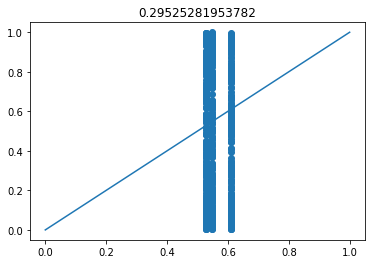

  0%|          | 0/25 [00:00<?, ?it/s]

/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


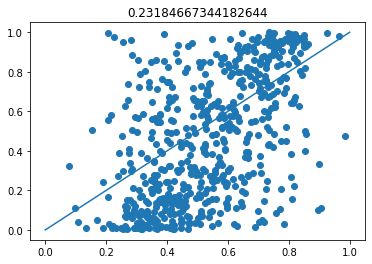

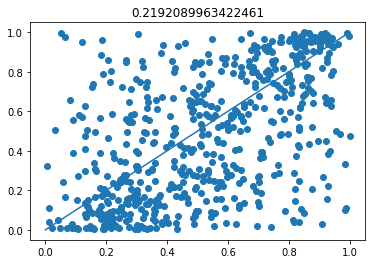

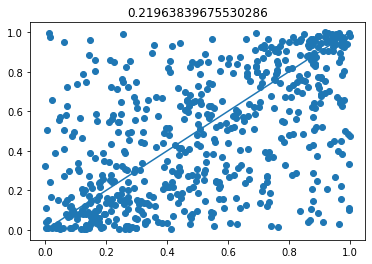

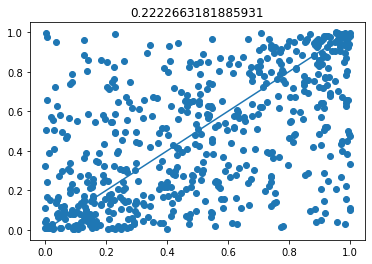

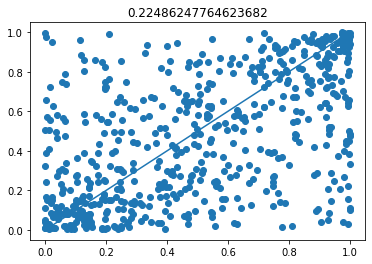

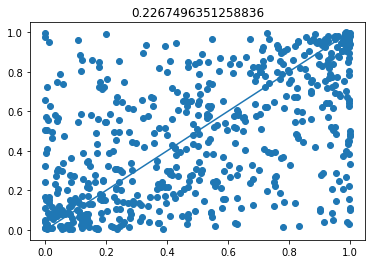

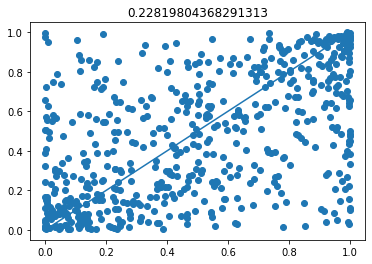

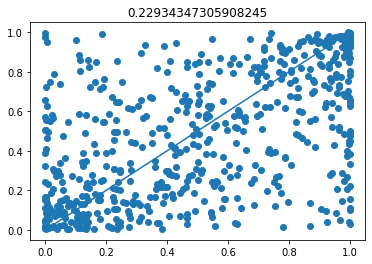

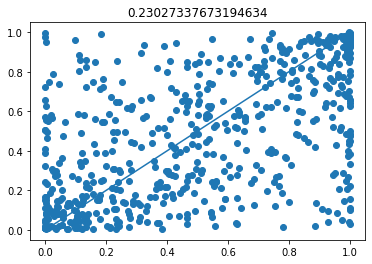

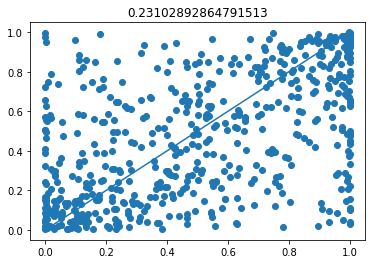

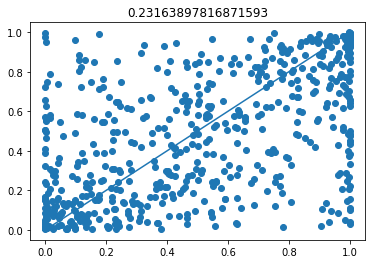

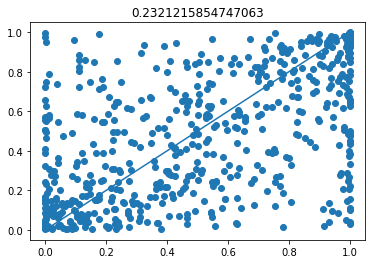

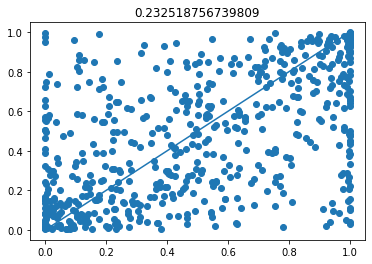

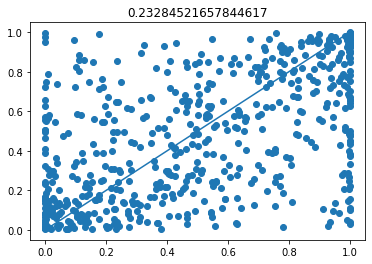

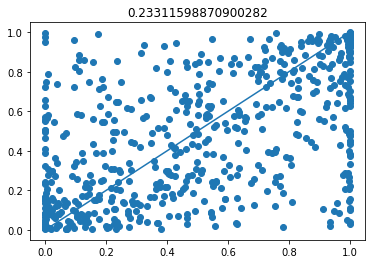

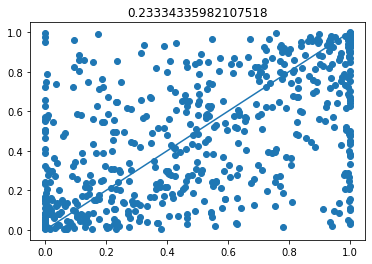

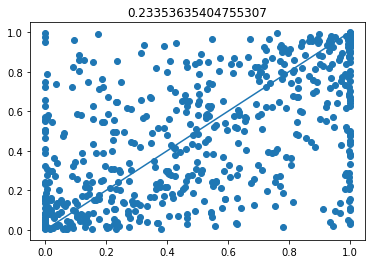

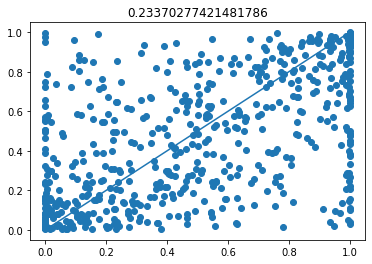

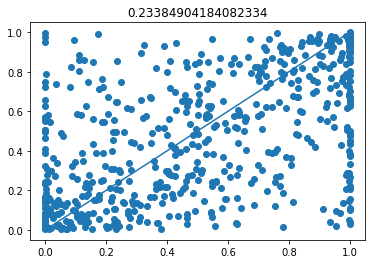

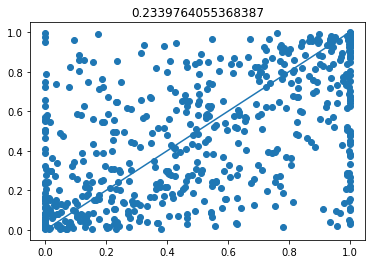

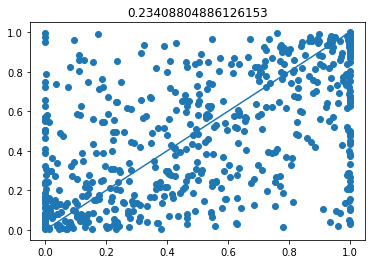

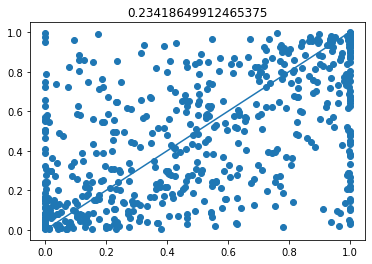

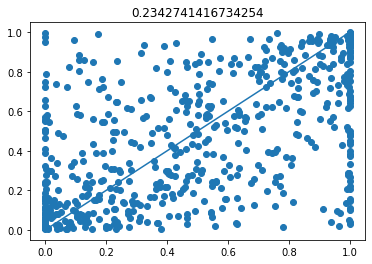

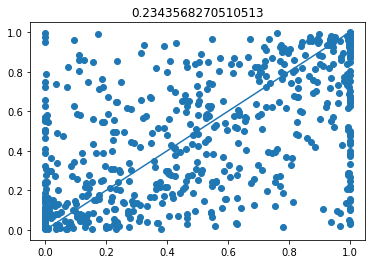

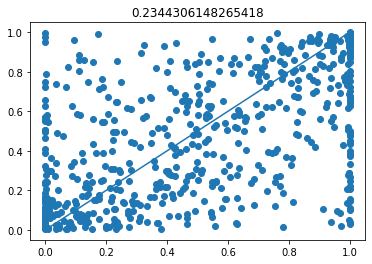

In [ ]:
drem.run("true posterior",componentInfo,)

In [ ]:
drem.getAUC()

0.9271401365140757

## Estimated PN Posterior 

  0%|          | 0/3 [00:00<?, ?it/s]

posterior auc  0.8975315335747818
posterior auc  0.8954740265167885
posterior auc  0.8438969569072088
0.8818676532231312


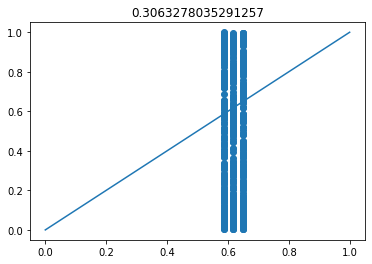

  0%|          | 0/25 [00:00<?, ?it/s]

/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dz/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


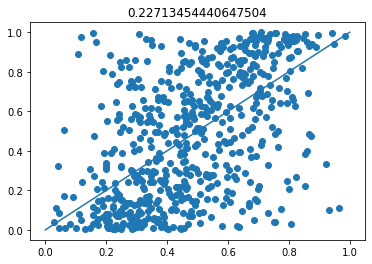

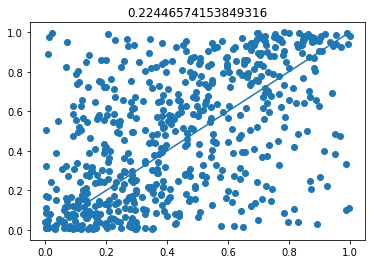

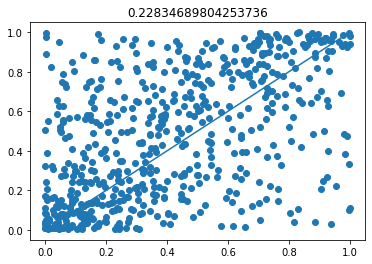

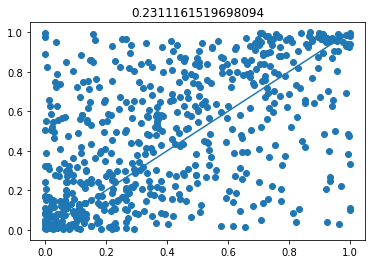

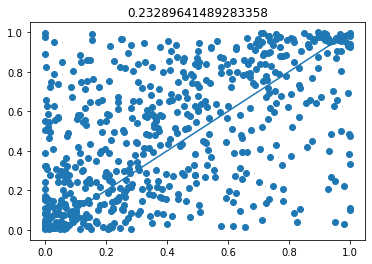

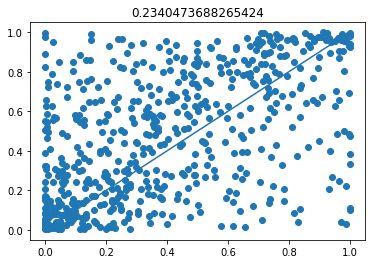

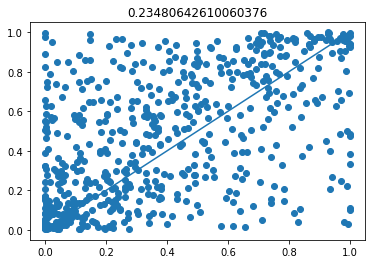

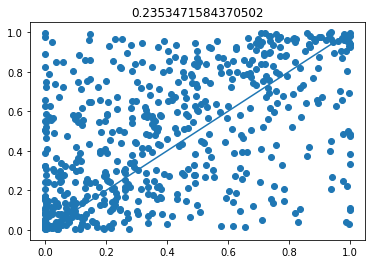

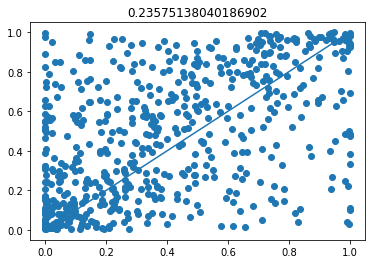

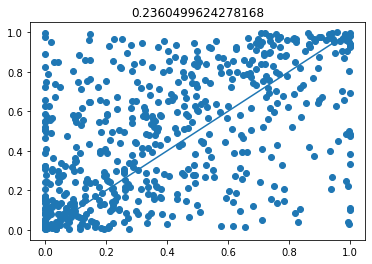

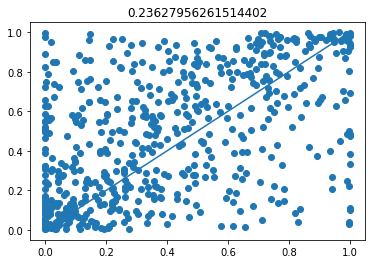

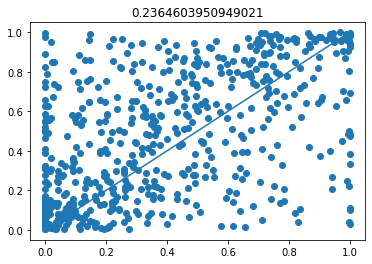

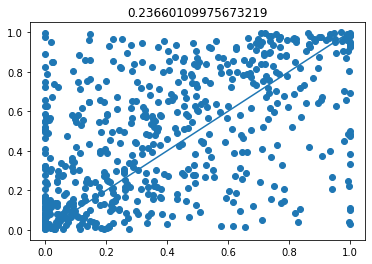

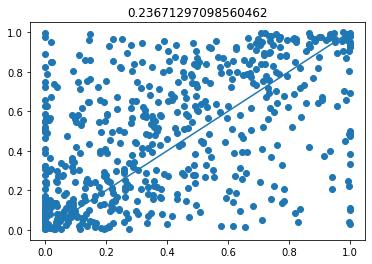

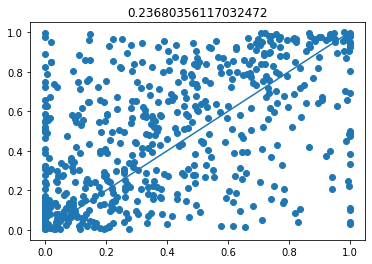

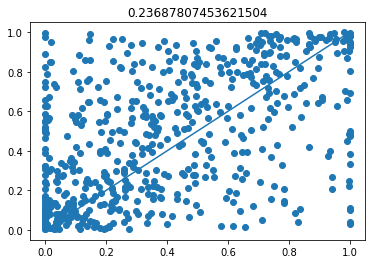

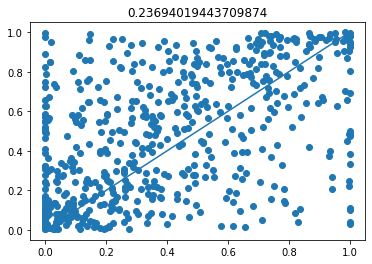

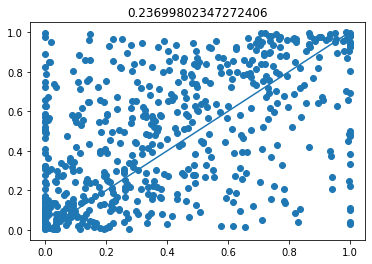

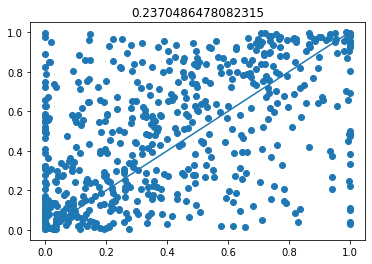

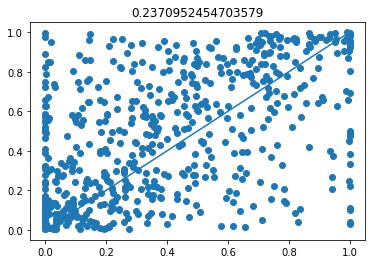

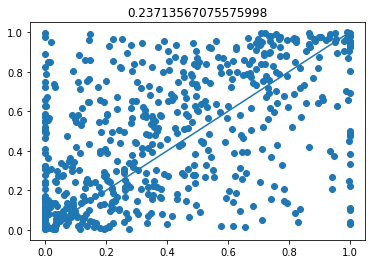

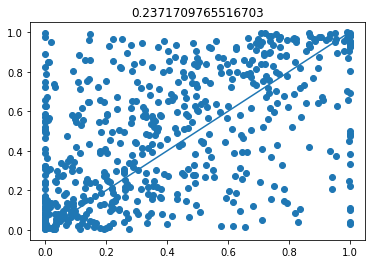

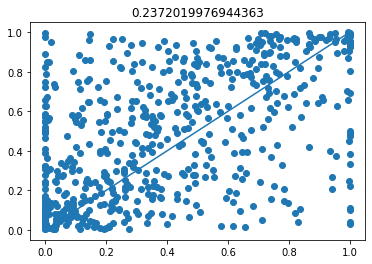

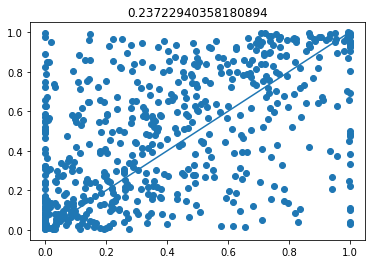

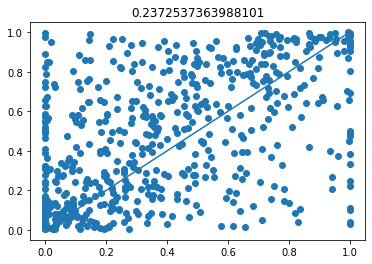

In [ ]:
drem.run("estimated posterior",componentInfo)

In [ ]:
drem.getAUC()

0.9242374484391594

## NNPU Raw

In [ ]:
drem.run("nnpu raw",componentInfo)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
drem.getAUC()

In [ ]:
np.mean(np.abs(drem.eta - trueEta))

In [ ]:
np.mean(np.abs(drem.alphaHats - [b.alpha for b in bags]))

In [ ]:
rawPosts = drem.debugPosteriors
rawRatios = drem.bagRatios

In [ ]:
plt.scatter(np.concatenate(rawPosts), np.concatenate(truePosts),alpha=.05)
plt.plot([0,1],[0,1],color="black")

In [ ]:
np.mean(np.abs(np.concatenate(rawPosts) - np.concatenate(truePosts)))

In [ ]:
plt.scatter(np.log(np.concatenate([np.concatenate(r) for r in rawRatios])),
            np.log(np.concatenate([np.concatenate(r) for r in trueRatios])),alpha=.25)
plt.plot([-15,5],[-15,5])

In [ ]:
drem.getAUC()

In [ ]:
drem.run("nnpu transform")

In [ ]:
drem.getAUC()

In [ ]:
drem.run("nnpu estimated rank")

In [ ]:
drem.getAUC()

In [ ]:
drem.run("nnpu true rank",componentInfo=componentInfo)

In [ ]:
drem.getAUC()

In [ ]:
baseline(bags)

# Experiment 1
NClusters = 3
Dim = 2
aucpn_range=  [.8,1.]
NBags = 250
NPos = 10
NUnlabeled = 25


* true posterior : 0.747
* nnpu transform : 0.708
* nnpu raw : 0.692
* nnpu true rank : 0.66
* baseline : 0.578
* nnpu est rank : 0.575
* Estimated posterior : 0.54

nnpu raw outperforms the baseline when there is a large number of small bags. This is the expected result as the class prior and posterior estimates are difficult in the small data setting.

# Experiment 2
NClusters = 1
Dim = 2
aucpn_range=  [.8,1.]
NBags = 1
NPos = 500
NUnlabeled = 1000

* NNPU Estimated Rank : 0.935
* True Posterior : 0.898
* NNPU True Rank : 0.897
* Estimated Posterior : 0.862
* Baseline : 0.802
* NNPU Raw : 0.787
* NNPU Transform : 0.66


# Experiment 3
NClusters = 1
Dim = 2
aucpn_range=  [.8,1.]
NBags = 50
NPos = 50
NUnlabeled = 100

* True Posterior : 0.884
* NNPU Transform : 0.864
* NNPU Raw : 0.86
* NNPU True Rank : 0.695
* NNPU Estimated Rank : 0.682
* Estimated Posterior : 0.58 (posterior auc 0.836)


In [ ]:
drem.eta

In [ ]:
for p,r in zip(drem.bagRatios,ratios):
    for pi,ri in zip(p,r):
        plt.hist(pi)
        plt.hist(ri,color="red",alpha=.25)
        plt.show()

In [ ]:
plt.hist([drem.debugPosteriors[i].max() for i in range(len(drem.debugPosteriors))])

# Experiment 4
NClusters = 3
Dim = 2
aucpn_range=  [.8,1.]
NBags = 1
NPos = 100
NUnlabeled = 1000

* True Posterior : 0.775
* Estimated Posterior : 0.719 posterior cluster aucs : (.72, 86, .68)
* Baseline : 0.698
* NNPU Raw : 0.603
* NNPU Estimated Rank : 0.33
* NNPU True Rank : 0.3255
* NNPU Transform : 0.309


# Experiment 5
NClusters = 3
Dim = 2
aucpn_range=  [.8,1.]
NBags = 10
NPos = 100
NUnlabeled = 1000

* True Rank : 0.818
* True Posterior : 0.77
* NNPU Raw : 0.757
* NNPU Transform :  0.711
* Estimated Posterior : 0.69 (0.69, .87, .77) 
* Baseline : 0.656
* Estimated Rank : 0.56


# Experiment 6
NClusters = 3
Dim = 2
aucpn_range=  [.8,1.]
NBags = 100
NPos = 100
NUnlabeled = 1000

* True Posterior : 0.907
* True Rank : 0.89
* NNPU Raw : 0.798
* NNPU Transform : 0.710
* baseline : 0.69
* Est. Posterior : 0.61
    * posteriors auc 0.878
    * posteriors auc 0.860
    * posteriors auc 0.833
* Est Rank : 0.601

$\frac{n_p + \alpha n_u}{n_p + n_u}$

# Experiments for Table

# Experiment 000
NClusters = 3
Dim = 256
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25


# Experiment 00
NClusters = 3
Dim = 128
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25

* True Posterior
    * 0.86 p(y=1|x,c_1)
    * 0.95 p(y=1|x,c_2)
    * 0.8  p(y=1|x,c_3)
    * p(y=1|x,c_k) : 0.9 prior used : p(y=1|c_k)
    * p(y=1|x,c_k,b_i) : 0.88
* Estimated Posterior
    * 0.75
    * 0.86
    * 0.77
    * 0.81
    * 0.59
* NNPU Raw
    * 0.78
    * 0.89
    * 0.52
    * 0.78
    * 0.68
* NNPU Transform
    * 0.61
    * 0.73
    * 0.61
    * 0.62
    * 0.61
* NNPU Est Rank
    * 0.558
* NNPU True Rank
    * 0.86
    * 0.95
    * 0.86
    * 0.89
    * 0.8


# Experiment 0
NClusters = 3
Dim = 64
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25

* True Posterior : 0.876
* True Rank : 0.79
* NNPU Transform : 0.704
* NNPU Raw : 0.628
* Estimated Rank : 0.58
* Estimated Posterior : 0.573
    * posterior auc  0.822
    * posterior auc  0.855
    * posterior auc  0.849
    * 0.83
* baseline : 0.52 (700/1000 bags seems to have stabilized)


# Experiment 1
NClusters = 3
Dim = 32
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25

* True Posterior : 0.83
* True Rank : 0.76
* NNPU Raw : 0.736
* NNPU Transform : 0.685
* Est Rank : 0.587
* Estimated Poster : 0.542
    * Cluster AUCs : .83, .80, .77
    * Merged AUC calculated directly : 0.798
* baseline : 0.52

# Experiment 2
NClusters = 3
Dim = 16
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25

* True Posterior : 0.785
* NNPU True Rank : 0.73
* NNPU Transform : 0.65
* Estimated Posterior : 0.63
    * .78, .79, .74
* NNPU Raw : 0.595
* NNPU Estimated Rank : 0.54
* baseline : 0.527

# Experiment 3

NClusters = 3
Dim = 8
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25

* True Posterior : 0.755
* True Rank : 0.714
* NNPU Transform : 0.642
* Estimated Posterior : 0.637
    * posterior auc  0.758
    * posterior auc  0.759
    * posterior auc  0.757
    * 0.758
* NNPU Raw : 0.6355
* Estimated Rank : 0.572
* baseline : 0.513

# Experiment 4
NClusters = 3
Dim = 4
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25
* True Posterior
    * C1 : 0.82
    * C2 : 0.81
    * C3 : 0.81
    * Overall : 0.815
    * Final : 0.77
    
* Estimated Posterior
    * 0.80
    * 0.80
    * 0.78
    * 0.796
    * 0.765
    
* True Rank
    * 0.82
    * 0.81
    * 0.81
    * 0.81
    * 0.75
* Raw
    * 0.807
    * 0.797
    * 0.791
    * 0.784
    * 0.693

* Estimated Rank
    * 0.6544

* Transform
    * 0.72
    * 0.703
    * 0.698
    * 0.70
    * 0.64



* baseline:
    * 0.56

# Experiment 5
NClusters = 3
Dim = 2
aucpn_range=  [.8,1.]
NBags = 1000
NPos = 10
NUnlabeled = 25
* True Posterior : 
    * 0.87
    * 0.81
    * 0.81
    * 0.81
    * 0.79

* Estimated Posterior :
    * 0.87
    * 0.80
    * 0.81
    * 0.83
    * 0.76
    
* Raw
    * 0.87
    * 0.80
    * 0.81
    * 0.72
    * 0.69
* Transform
    * 0.75
    * 0.65
    * 0.66
    * 0.66
    * 0.63
* Est Rank

* True Rank
* Baseline
